In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загрузка, предпросмотр и фильтрация данных за май 2016

In [2]:
fields = ['tpep_pickup_datetime','pickup_latitude','pickup_longitude',
          'tpep_dropoff_datetime','dropoff_latitude','dropoff_longitude',
          'passenger_count','trip_distance']
parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime']
dataframe_base = pd.read_csv("yellow_tripdata_2016-05.csv",usecols=fields, parse_dates=parse_dates)

In [3]:
# for testing
#df = dataframe_base[:50000]

In [4]:
df = dataframe_base

In [23]:
df.head(7)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,-73.983986,40.730099
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,-73.975700,40.765469
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,-73.980995,40.744633
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,-74.002258,40.733002
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,-73.997498,40.737564
5,2016-05-01,2016-05-01 00:05:19,2,0.63,-73.979294,40.755764,-73.988014,40.758469
6,2016-05-01,2016-05-01 00:15:43,1,6.68,-73.981544,40.780739,-73.937805,40.855343


In [7]:
#df.describe()

Удаляем аномалии:

- нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

In [5]:
# Координаты Нью-Йорка
ymin = 40.49612
ymax = 40.91553
xmin = -74.25559
xmax = -73.70001

In [6]:
df = df.drop(df[df.tpep_pickup_datetime == df.tpep_dropoff_datetime].index, axis = 0)
df = df.drop(df[df.passenger_count == 0].index, axis = 0)
df = df.drop(df[df.trip_distance == 0].index, axis = 0)

In [7]:
# начало поездки не в NY
df = df.drop(df[(df.pickup_latitude < ymin)  | (df.pickup_latitude > ymax)].index, axis = 0)

In [8]:
df = df.drop(df[(df.pickup_longitude < xmin) | (df.pickup_longitude > xmax)].index, axis = 0)

In [9]:
# отбросить минуты и секунды в начале поезки
# long operation...
df['pickup_datetime'] = df['tpep_pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H'))

In [10]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

In [11]:
#df = df.drop('tpep_pickup_datetime', axis = 1)

In [12]:
split_n = 50
step_x = (xmax - xmin) / split_n
step_y = (ymax - ymin) / split_n

In [13]:
# восстанавливаем лейблы регионов
regions = pd.read_csv("regions.csv", sep = ';')

In [16]:
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [14]:
def get_region(coord):   
    x = int((coord[0] - xmin) / step_x)
    y = int((coord[1] - ymin) / step_y)
    if (x == 0):
        dLon = x + 1
    return x * split_n + y + 1

In [15]:
# тест для ЭСБ
get_region([-73.98603, 40.74853])

1231

In [16]:
# long operation...
df['region'] = df[['pickup_longitude','pickup_latitude']].apply(get_region, axis = 1)

In [17]:
df.to_csv("may_with_region.csv", sep =';')

In [18]:
df.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime,pickup_hour,region
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,-73.983986,40.730099,2016-05-01 00,0,1233
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,-73.975700,40.765469,2016-05-01 00,0,1180
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,-73.980995,40.744633,2016-05-01 00,0,1180
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,-74.002258,40.733002,2016-05-01 00,0,1173
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,-73.997498,40.737564,2016-05-01 00,0,1130


Агрегируем данные по часам и областям

In [112]:
grouped = df[["pickup_datetime","region"]].groupby(["pickup_datetime","region"], axis=0)['region'].count()
grouped.unstack()

region,15,16,25,27,32,45,49,61,77,80,...,2476,2478,2479,2481,2482,2483,2484,2485,2486,2487
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
region = np.arange(1, 2501)

pickup_date = pd.date_range('2016-05-01 00', '2016-05-31 23', freq="H").strftime('%Y-%m-%d %H')
midx = pd.MultiIndex.from_product([       
        pickup_date,
        region
    ], names=['pickup_datetime','region'])


In [121]:
group_counts = grouped.reindex(midx, fill_value=0).to_frame(name = 'count')

In [123]:
group_counts.head(20)

count
pickup_datetime region       
2016-05-01 00   1           0
                2           0
                3           0
                4           0
                5           0
                6           0
                7           0
                8           0
                9           0
                10          0
                11          0
                12          0
                13          0
                14          0
                15          0
                16          0
                17          0
                18          0
                19          0
                20          0

Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [124]:
empire_st_bld_region = get_region([-73.98603, 40.74853])
rides = []
for i in pickup_date:
    rides.append(group_counts['count'][i][empire_st_bld_region])

In [139]:
df_rides = pd.DataFrame(rides, index = pickup_date,columns = ['count'])

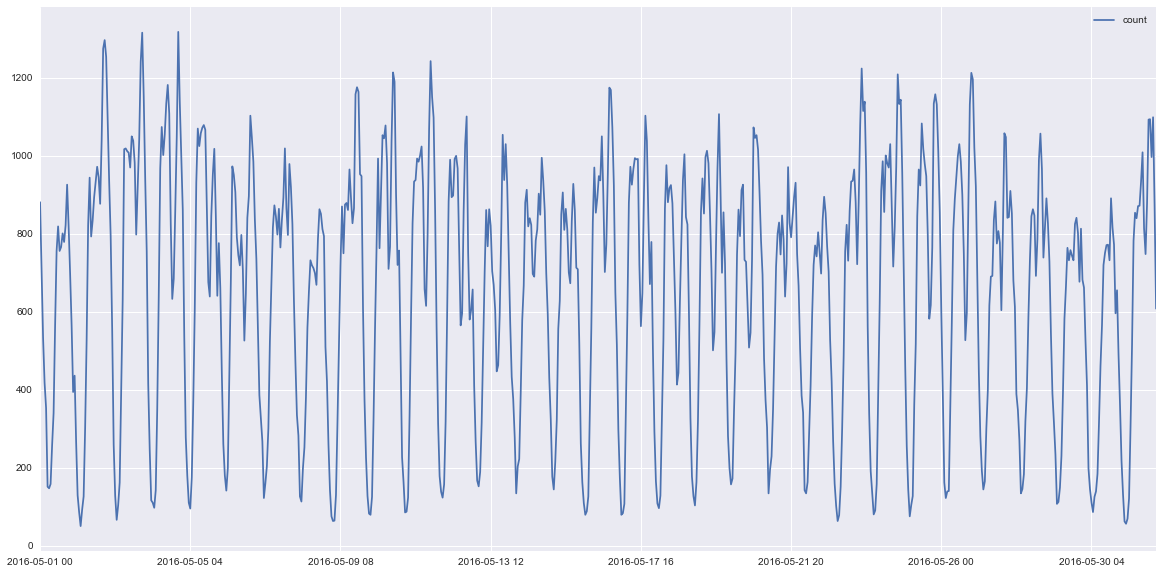

In [145]:
df_rides.plot()

In [125]:
# число записей час-район, который содержит только нули
group_counts['count'].value_counts()[0]

1718238